# Interaction wake-cylinder ($Re=40$)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ibmos as ib

## Numerical grid and solver initialization

In [3]:
passages = 1

In [5]:
s1 = ib.stretching(192, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
s2 = ib.stretching(64, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
x = np.concatenate([-s2[::-1], s1[1:]])

s = ib.stretching(31, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
y0 = np.concatenate([-s[::-1], s[1:]])

Ly = y0[-1] - y0[0]

y = np.concatenate([y0,] + [y0[1:] + k*Ly for k in range(1, passages) ])

solver = ib.Solver(x, y, periodic=True, iRe=1/40.0, Co=2*(y[-1]-y[0])/284*0.5/0.02) 

In [6]:
(len(y)-1)/3

20.0

## Immersed boundaries

In [7]:
solver.set_solids(*[ib.shapes.cylinder("cyl[%d]"%k, 0, k*Ly, 0.5, solver.dxmin) for k in range(passages)])

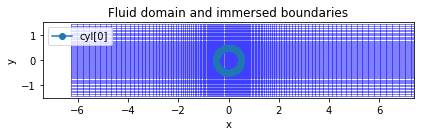

In [8]:
solver.plot_domain(figsize=(6, 2), xlim=(-4, 4), ylim=(-1.5, 1.5))

## Boundary conditions and initial condition

In [11]:
f = np.load('401-WakeCylinderUnsteady-X.npz')
x0, t0 = f['x0'], f['t0']

In [13]:
fuBC = (lambda s, t: 1.52-1.1*np.sin(np.pi*(s-y[0]-0.5*t0)/(y[-1]-y[0]))**2,
        lambda s, t: 0.97*np.ones_like(s) )
fvBC = (lambda s, t: 0.04*np.sin(2*np.pi*(s-y[0]-0.5*t0)/(y[-1]-y[0])),
        lambda s, t: np.zeros_like(s))

fsBC = ((lambda ξ, η, t: np.zeros_like(ξ),)*2, )

## Unsteady simulation

In [14]:
%%time 
x, t, infodict = solver.steps(x0, fuBC, fvBC, fsBC, t0=t0, outflowEast=True, 
                              saveEvery=1, number=248, verbose=1)

       k            t          x_2       dxdt_2    cyl[0]_fx    cyl[0]_fy  Uinf@outlet 
       1  9.00400e+01  1.60092e+02  1.13780e+03  3.07881e+00 -2.76749e-02  9.70000e-01 
       2  9.00600e+01  1.59842e+02  3.31072e+01  3.07634e+00 -2.11930e-02  9.70000e-01 
       3  9.00800e+01  1.59627e+02  3.01243e+01  3.07415e+00 -1.61749e-02  9.70000e-01 
       4  9.01000e+01  1.59422e+02  2.96025e+01  3.07210e+00 -1.11704e-02  9.70000e-01 
       5  9.01200e+01  1.59224e+02  2.91682e+01  3.07020e+00 -6.15708e-03  9.70000e-01 
       6  9.01400e+01  1.59033e+02  2.87766e+01  3.06845e+00 -1.13723e-03  9.70000e-01 
       7  9.01600e+01  1.58849e+02  2.84189e+01  3.06686e+00  3.88694e-03  9.70000e-01 
       8  9.01800e+01  1.58672e+02  2.80924e+01  3.06542e+00  8.91320e-03  9.70000e-01 
       9  9.02000e+01  1.58502e+02  2.77954e+01  3.06413e+00  1.39393e-02  9.70000e-01 
      10  9.02200e+01  1.58337e+02  2.75257e+01  3.06300e+00  1.89630e-02  9.70000e-01 
      11  9.02400e+01  1.58179e+

## Display results

Display velocity field and pressure at the last time step

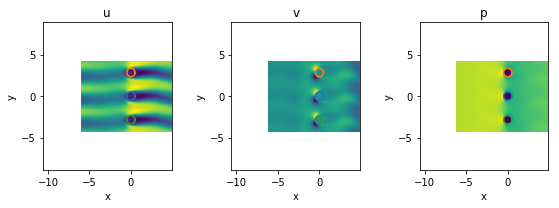

In [15]:
solver.plot_field(x[-1], equal=True, xlim=(-10, 4.3), ylim=(-2, 2));

Temporal evolution of the force coefficients

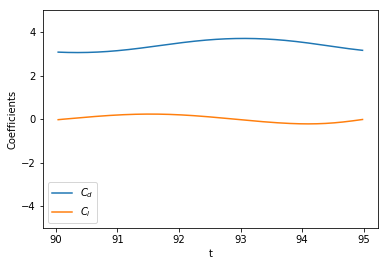

In [16]:
plt.plot(infodict['t'], infodict['cyl[0]_fx'], label=r'$C_d$')
plt.plot(infodict['t'], infodict['cyl[0]_fy'], label=r'$C_l$')
plt.ylim(-5, 5)
plt.xlabel('t')
plt.ylabel('Coefficients')
plt.legend();

Animation

In [17]:
from IPython.display import HTML
from matplotlib import animation
%config InlineBackend.figure_format = 'png'

<Figure size 432x288 with 0 Axes>

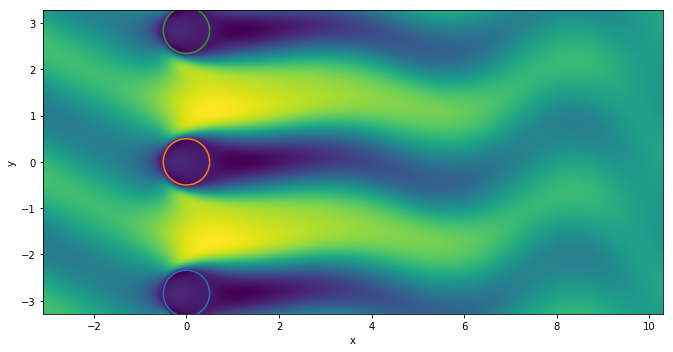

In [18]:
plt.figure()
fig, ax = plt.subplots(figsize=(9.5, 5))
Ly = (y[-1]-y[0])
quad = ax.pcolormesh(solver.fluid.u.x, 
                     np.r_[solver.fluid.u.y - Ly, solver.fluid.u.y, solver.fluid.u.y + Ly],
                     np.vstack([solver.reshape(*solver.unpack(x[0]))[0],]*3),
                     rasterized=True, shading='gouraud')

for solid in solver.solids:
    plt.plot(solid.ξ, solid.η-Ly)
    plt.plot(solid.ξ, solid.η)
    plt.plot(solid.ξ, solid.η+Ly)
    
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2.8, 10)
ax.set_ylim(-2, 2)
fig.tight_layout()

In [19]:
def init():
    quad.set_array([])
    return quad,

def animate(i):
    array = np.r_[solver.unpack(x[i])[0].ravel(), solver.unpack(x[i])[0].ravel(),solver.unpack(x[i])[0].ravel()]
    quad.set_array(array)
    return quad,

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=len(x), interval=15, blit=True)

In [20]:
%time HTML(anim.to_html5_video())

CPU times: user 53 s, sys: 188 ms, total: 53.2 s
Wall time: 54.1 s


(0, 5)

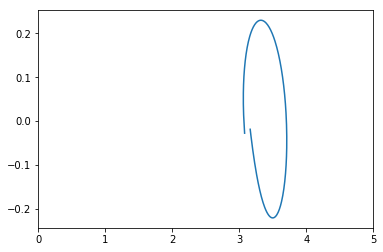

In [21]:
plt.plot(infodict['cyl[0]_fx'], infodict['cyl[0]_fy'])
plt.xlim(0, 5)